## Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import log_loss,confusion_matrix,classification_report,roc_curve,auc
from sklearn.pipeline import Pipeline
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
%matplotlib inline
seed = 2390

## Read data set

In [3]:
path = 'file/'
#path = '../input/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
print('Number of rows and columns in the train data set:',train.shape)
print('Number of rows and columns in the test data set:',test.shape)

Number of rows and columns in the train data set: (95851, 8)
Number of rows and columns in the test data set: (226998, 2)


In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,22256635,"Nonsense? kiss off, geek. what I said is true...",1,0,0,0,0,0
1,27450690,"""\n\n Please do not vandalize pages, as you di...",0,0,0,0,0,0
2,54037174,"""\n\n """"Points of interest"""" \n\nI removed the...",0,0,0,0,0,0
3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [5]:
test.head()

,id,comment_text
0,6044863,==Orphaned non-free media (Image:41cD1jboEvL. ...
1,6102620,::Kentuckiana is colloquial. Even though the ...
2,14563293,"Hello fellow Wikipedians,\nI have just modifie..."
3,21086297,"AKC Suspensions \nThe Morning Call - Feb 24, 2..."
4,22982444,== [WIKI_LINK: Talk:Celts] ==


In [6]:
def rmsle(y_true,y_pred):
    assert len(y_true) == len(y_pred)
    return np.mean(np.log(y_true + 1) + np.log(y_pred + 1))

## Target varaible distribution

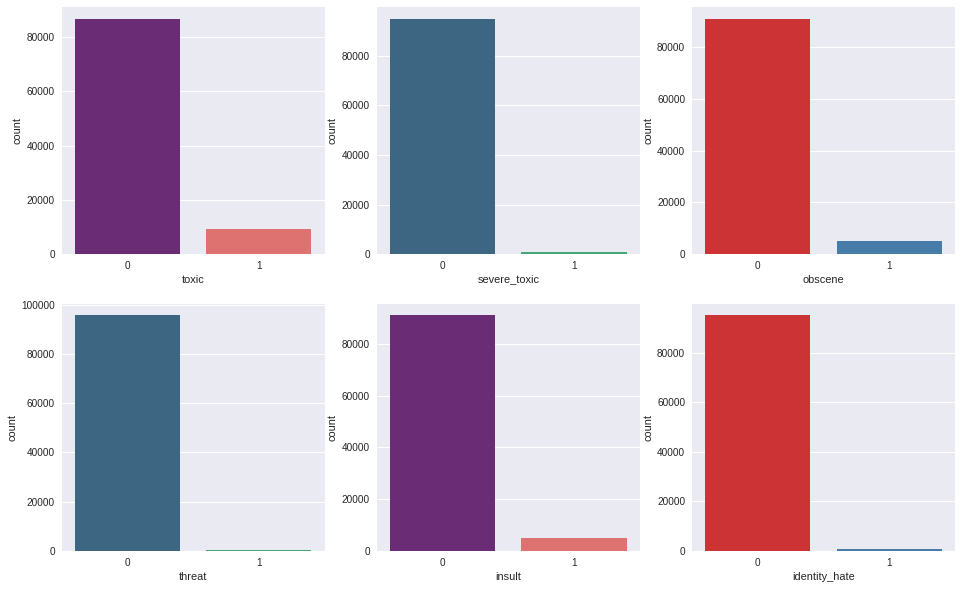

In [25]:
fig,ax = plt.subplots(2,3,figsize=(16,10))
ax1,ax2,ax3,ax4,ax5,ax6 = ax.flatten()
sns.countplot(train['toxic'],palette= 'magma',ax=ax1)
sns.countplot(train['severe_toxic'], palette= 'viridis',ax=ax2)
sns.countplot(train['obscene'], palette= 'Set1',ax=ax3)
sns.countplot(train['threat'], palette= 'viridis',ax = ax4)
sns.countplot(train['insult'], palette = 'magma',ax=ax5)
sns.countplot(train['identity_hate'], palette = 'Set1', ax = ax6)

## Missing value

In [11]:
k = pd.DataFrame()
k['train'] = train.isnull().sum()
k['tes'] = test.isnull().sum()
k

,train,tes
id,0,0.0
comment_text,0,0.0
toxic,0,NaN
severe_toxic,0,NaN
obscene,0,NaN
threat,0,NaN
insult,0,NaN
identity_hate,0,NaN


In [7]:
test[test['comment_text'].isnull()]

,id,comment_text
52300,231298963278,NaN


In [8]:
test.fillna(' ',inplace=True)
gc.collect()

0

## Text feature

In [ ]:
 def text_charcter(df):
        
        df['num_word'] = df['comment_text'].apply(lambda x: len(str(x).split()))
        df['num_unique_word'] = df['comment_text'].apply(lambda x: len(set(str(x).split())))
        df['num_char_word'] = df['comment_text'].apply(lambda x: len(str(x)))
        df['num_punc_word'] = df['comment_text'].apply(lambda x: len([w for w in str(x) if w in string.punctuation]))
        df['num_stopword'] = df['comment_text'].apply(lambda x: len([w for w in str(x).lower().split() 
                                                                        if w in set(stopwords.words('english'))]))
        df['num_upper_word'] = df['comment_text'].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
        df['num_title_word'] = df['comment_text'].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
        df['mean_word_len'] = df['comment_text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
text_charcter(train)
text_charcter(test)

## Text preprosesing

In [12]:
tfidf = TfidfVectorizer(max_features=20000, lowercase=True, analyzer='word',min_df=1,max_df=0.9,token_pattern=r'\w{1,}',
                        #tokenizer= word_tokenize, 
                        stop_words= 'english',ngram_range=(1,3),dtype=np.float32)

In [12]:
cont_vect = CountVectorizer(max_features=10, lowercase=True, analyzer='word', 
                            stop_words = stopwords.words('english'),ngram_range=(1,3),dtype=np.int8)

In [ ]:
"""cont_vect.fit(list(train['comment_text']) + list(test['comment_text']))
train_cv = cont_vect.transform(train['comment_text']).toarray()
test_cv = cont_vect.transform(test['comment_text']).toarray() """

tfidf.fit(list(train['comment_text']) + list(test['comment_text']))
train_tf = tfidf.transform(train['comment_text']).toarray()
test_tf = tfidf.transform(test['comment_text']).toarray()
gc.collect()

In [15]:
svd = TruncatedSVD(n_components= 200,random_state=seed)
train_svd = svd.fit_transform(train_tf)
test_svd = svd.fit_transform(test_tf)

In [16]:
X = train_svd
y = train.drop(['id','comment_text'],axis=1)
x_test = test_svd
del train_tf,test_tf,train_svd,test_svd
gc.collect()

0

## Model

In [18]:
lr = LogisticRegression(C=4)
prd = np.zeros((len(x_test),y.shape[1]))
cv_score =[]
for i,col in enumerate( y.columns):
    print('Building model for column:',col) 
    lr.fit(X,y[col])
    #cv_score.append(lr.score)
    prd[:,i] = lr.predict_proba(x_test)[:,1]
    

Building model for column: toxic
Building model for column: severe_toxic
Building model for column: obscene
Building model for column: threat
Building model for column: insult
Building model for column: identity_hate


## Model Validation on train data set

In [37]:
print("Column:",col)
pred =  lr.predict(X)
print('\nConfusion matrix\n',confusion_matrix(y[col],pred))
print(classification_report(y[col],pred))

Column: identity_hate

Confusion matrix
 [[95004    33]
 [  762    52]]
             precision    recall  f1-score   support

          0       0.99      1.00      1.00     95037
          1       0.61      0.06      0.12       814

avg / total       0.99      0.99      0.99     95851



In [40]:
rmsle(y[col],pred)

0.006501124822102894

## Roc AUC curve

Column: identity_hate


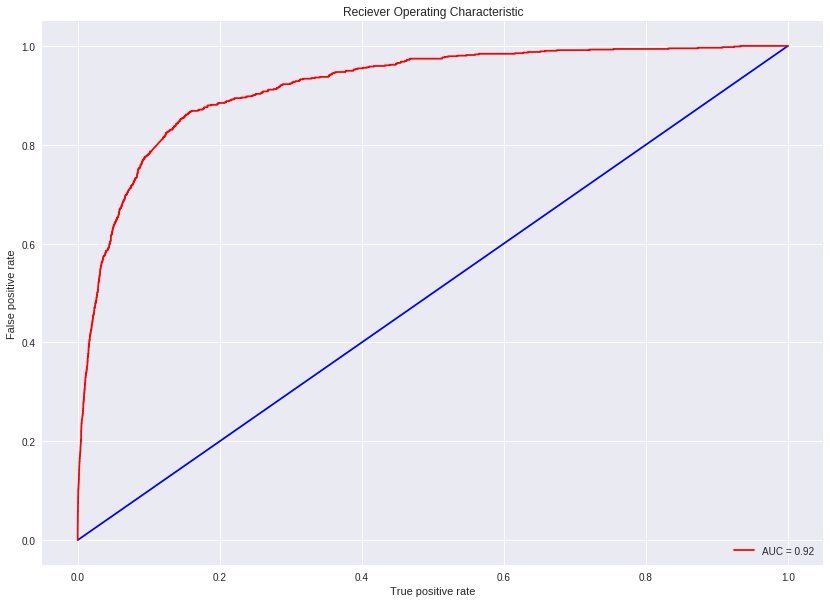

In [38]:
print("Column:",col)
pred_pro = lr.predict_proba(X)[:,1]
frp,trp,thres = roc_curve(y[col],pred_pro)
auc_val =auc(frp,trp)
plt.figure(figsize=(14,10))
plt.plot([0,1],[0,1],color='b')
plt.plot(frp,trp,color='r',label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('True positive rate')
plt.ylabel('False positive rate')
plt.title('Reciever Operating Characteristic')

## submission

In [35]:
prd_1 = pd.DataFrame(prd,columns=y.columns)
submit = pd.concat([test['id'],prd_1],axis=1)
submit.to_csv('toxic_lr.csv.gz',compression='gzip',index=False)
#submit.to_csv('toxic_lr.csv',index=False)
submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,6044863,0.000862,0.000609,0.000462,0.001307,0.000847,0.000198
1,6102620,0.033135,0.004877,0.010675,0.003757,0.032741,0.010279
2,14563293,0.422656,0.044241,0.205835,0.018976,0.323498,0.017892
3,21086297,0.107244,0.009078,0.041196,0.004959,0.049525,0.012407
4,22982444,0.999897,0.006249,0.992308,0.000829,0.284710,0.008872


### Thank you